In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython import display
import pylab as pl

from NSMBSS import *
from ICA import fit_icainfomax
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Image Separation'

# np.random.seed(250)

In [2]:
image_paths = '../../data/TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [3]:
image_height_and_width = [454, 605]
small_images = np.zeros((images.shape[0],image_height_and_width[0]* image_height_and_width[1]* 3))
small_to_large_image_size_ratio = 0.15
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    print(small_img.shape)
    if small_img.shape[0] == 486:
        small_img = cv2.resize(small_img, (0,0), fx = 454/486, fy = 605/648)

    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)


(14, 824010)

<IPython.core.display.Math object>

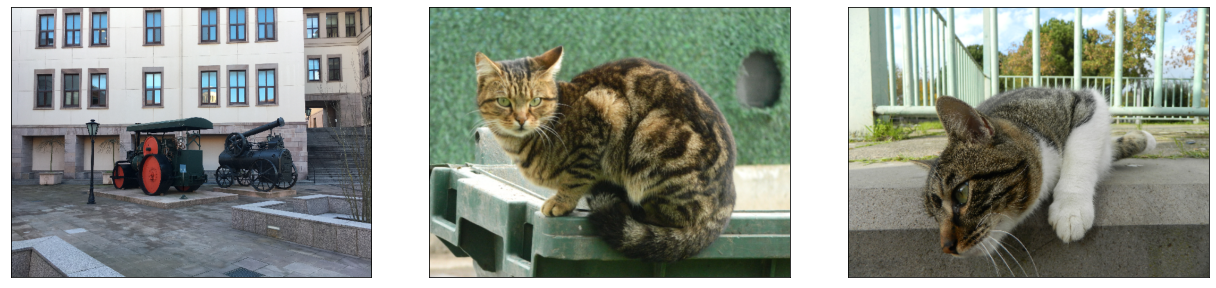

In [4]:
S = small_images[[12,6,3]]
Subplot_RGB_images(S, imsize = image_height_and_width, height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [5]:
np.random.seed(650)
NumberofMixtures = 5
NumberofSources = 3

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

X_ = ZeroOneNormalizeColumns(X.T).T
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 39.998179949657654
Row standard deviation of mixtures : [0.49470436 0.68985465 0.35937612 0.38933594 0.20646696]


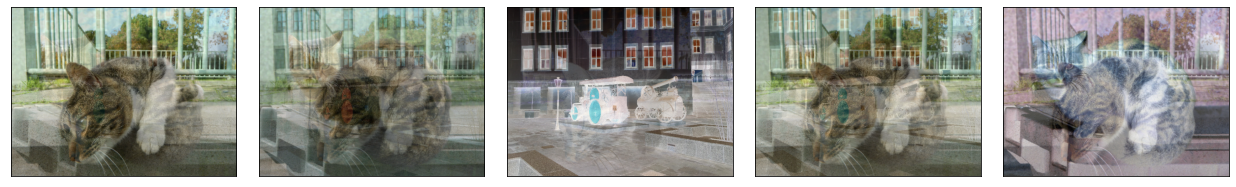

In [6]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

# NSM Algorithm

In [7]:
model = OnlineNSM(s_dim = NumberofSources, x_dim = NumberofMixtures, set_ground_truth = True, S = S, A = A)
model.fit_batch_nsm(X = X, debug_iteration_point = 50000, plot_in_jupyter = False)

100%|██████████| 824010/824010 [05:52<00:00, 2334.59it/s]


In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
OverallMatrix = Wf @ A
perm = np.argmax(OverallMatrix, axis = 0)
Y = (Wf @ X)[perm]
Y = ZeroOneNormalizeColumns(Y.T).T

SNR_levels = snr(S, Y)
PSNR_levels = []
for kk in range(S.shape[0]):
    PSNR_levels.append(psnr(S[kk], Y[kk]))

SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component SNR Values : {}\n".format(SNR_levels))
print("Component PSNR Values : {}\n".format(PSNR_levels))
print("Overall SINR : {}".format(SINR))

Component SNR Values : [20.59945346 19.84394306 21.71612072]

Component PSNR Values : [25.30151932794333, 26.49220979081974, 26.450648926857532]

Overall SINR : 24.023868096770524


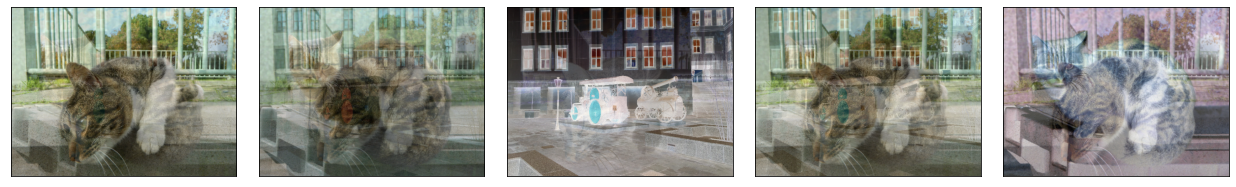

In [9]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)

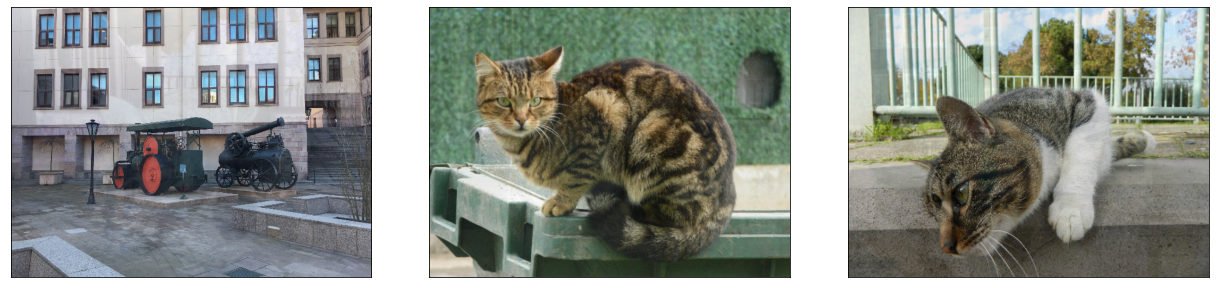

In [10]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y.T).T, imsize = image_height_and_width, height = 4, width = 18)
plt.savefig('NSM_Output.pdf', format = 'pdf', dpi = 1500)

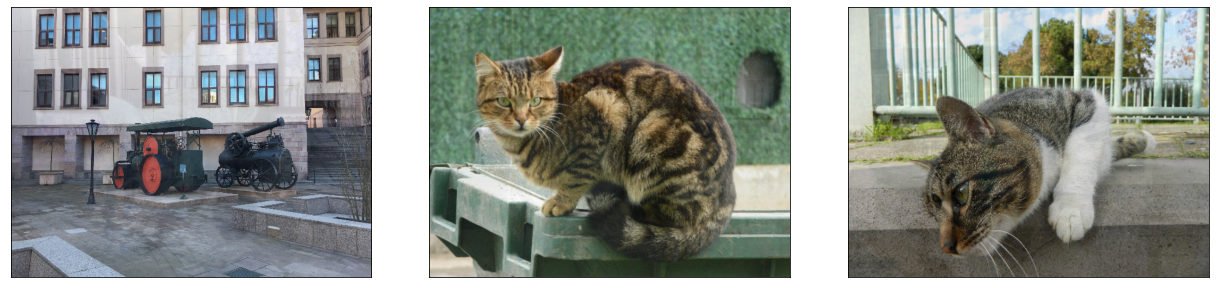

In [11]:
Subplot_RGB_images(np.clip(Y, 0,1), imsize = image_height_and_width, height = 4, width = 18)

# ICA InfoMax Algorithm

In [12]:
Y = fit_icainfomax(
    X,
    NumberofSources)

Creating RawArray with float64 data, n_channels=5, n_times=824010
    Range : 0 ... 824009 =      0.000 ...   412.005 secs
Ready.


In [13]:
S[kk]

array([0.85490196, 0.90196078, 0.8627451 , ..., 0.21960784, 0.22352941,
       0.18823529])

In [14]:
Y = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y * S).sum(axis=1) / (Y * Y).sum(axis=1)).reshape(-1, 1)
Y = coef_ * Y
Y = ZeroOneNormalizeColumns(Y.T).T
PSNR_levels = []
SNR_levels = snr(S, Y)
for kk in range(S.shape[0]):
    PSNR_levels.append(psnr(S[kk], Y[kk]))
    
SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component SNR Values : {}\n".format(SNR_levels))
print("Component PSNR Values : {}\n".format(PSNR_levels))
print("Overall SINR : {}".format(SINR))

Component SNR Values : [13.86513182 13.87732516 16.32975044]

Component PSNR Values : [18.567197687430877, 20.525591892432438, 21.064278646537065]

Overall SINR : 17.522320874817904


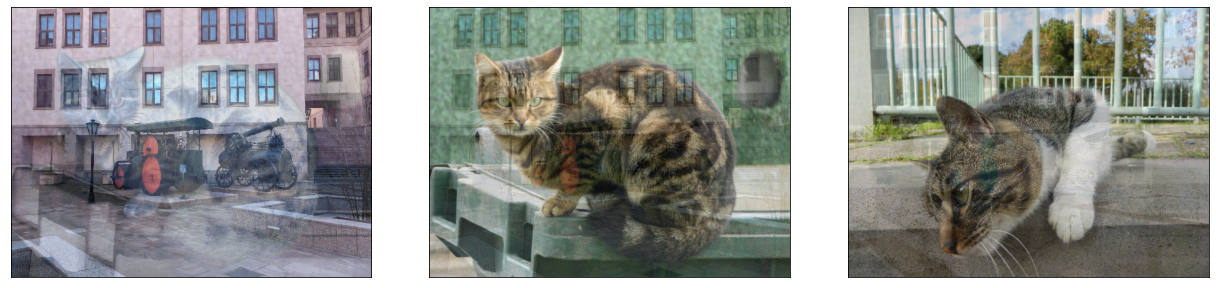

In [15]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y.T).T, imsize = image_height_and_width, height = 4, width = 18)
plt.savefig('ICA_Output.pdf', format = 'pdf', dpi = 1500)

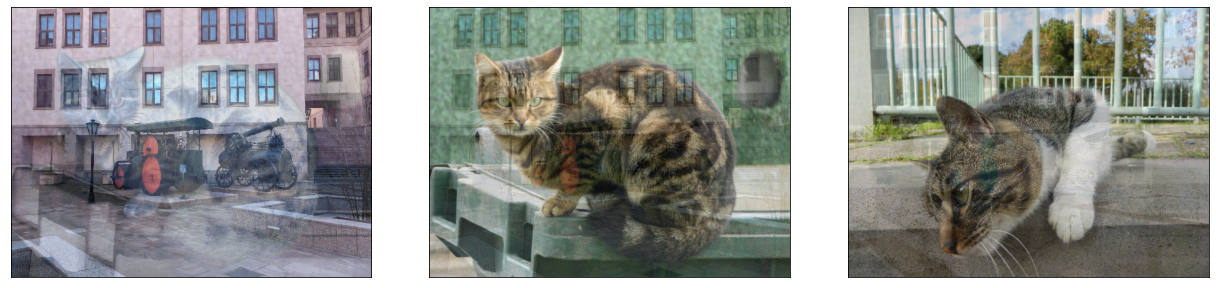

In [16]:
Subplot_RGB_images(np.clip(Y, 0,1), imsize = image_height_and_width, height = 4, width = 18)